In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd

# then import my own modules
from Featurization import save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [3]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FusedEmbedding(nn.Module):

    def __init__(self, radius, T, input_feature_dim, input_bond_dim,\
            fingerprint_dim, embedding_dim, output_units_num, p_dropout=0.0):
        super(FusedEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=p_dropout)
        self.atom_fc = nn.Linear(input_feature_dim, fingerprint_dim)        
        self.neighbor_fc = nn.Linear(input_feature_dim+input_bond_dim, fingerprint_dim)
        self.atom_GRU = nn.ModuleList([nn.GRUCell(fingerprint_dim, fingerprint_dim) for r in range(radius)])

        self.fused_GRU = nn.GRUCell(embedding_dim, fingerprint_dim)
        self.output = nn.Linear(fingerprint_dim, output_units_num) 
        self.radius = radius
        self.T = T
        self.embedding_dim = embedding_dim

    def forward(self, atom_list, bond_list, atom_degree_list, bond_degree_list, atom_mask, seq_embeddings):
        atom_mask = atom_mask.unsqueeze(2)
        batch_size,mol_length,num_atom_feat = atom_list.size()
        atom_feature = F.relu(self.atom_fc(atom_list)) * atom_mask

        bond_neighbor = [bond_list[i][bond_degree_list[i]] for i in range(batch_size)]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        atom_neighbor = [atom_list[i][atom_degree_list[i]] for i in range(batch_size)]
        atom_neighbor = torch.stack(atom_neighbor, dim=0)
        # then catenate them
        neighbor_feature = torch.cat([atom_neighbor, bond_neighbor],dim=-1)
#         print(neighbor_feature.shape, neighbor_feature[0][0])
        max_features = torch.max(neighbor_feature,dim=-2)[0]
        max_features = F.relu(self.neighbor_fc(max_features))
#         print(max_features.shape, max_features[0])
        batch_size, mol_length, fingerprint_dim = atom_feature.shape
        atom_feature_reshape = atom_feature.view(batch_size*mol_length, fingerprint_dim)
        max_features_reshape = max_features.view(batch_size*mol_length, fingerprint_dim)
        atom_feature_GRU = self.atom_GRU[0](max_features_reshape, atom_feature_reshape)
        atom_feature = atom_feature_GRU.view(batch_size, mol_length, fingerprint_dim) * atom_mask        

        for d in range(self.radius-1):
            neighbor_feature = [atom_feature[i][atom_degree_list[i]] for i in range(batch_size)]
            # neighbor_feature is a list of 3D tensor, so we need to stack them into a 4D tensor first
            neighbor_feature = torch.stack(neighbor_feature, dim=0)
            # then max-pooling 
            max_features = torch.max(neighbor_feature,dim=-2)[0]

            atom_feature_reshape = atom_feature.view(batch_size*mol_length, fingerprint_dim)
            max_features_reshape = max_features.view(batch_size*mol_length, fingerprint_dim)
            atom_feature_GRU = self.atom_GRU[d+1](max_features_reshape, atom_feature_reshape)
            atom_feature = atom_feature_GRU.view(batch_size, mol_length, fingerprint_dim) * atom_mask
        mol_feature = torch.sum(atom_feature,-2)            
        fused_feature = mol_feature
        for t in range(self.T):
            fused_feature = self.fused_GRU(seq_embeddings, fused_feature)
        fused_prediction = self.output(self.dropout(F.relu(fused_feature)))
        return fused_prediction

In [4]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd

number of all smiles:  2140
number of successfully processed smiles:  2140


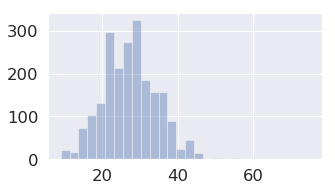

In [5]:
task_name = 'Multi-Targeting'
tasks = ['activity']
kinase_seq_embedding = pd.read_csv('../data/kinase_seq_embedding.csv')
smiles_kinase_activity = pd.read_csv('../data/smiles_kinase_activity.csv')

seq_embeddings_dict = {}
for kinase in list(set(smiles_kinase_activity['kinase'].values)):
    seq_embeddings_dict[kinase] = [float(x) for x in kinase_seq_embedding.loc[kinase_seq_embedding['kinase']==kinase].embedding.values[0]\
                                 .replace("[", "").replace("]", "").replace(" ", "").split(',')]

smiles_kinase_activity['embedding'] = [seq_embeddings_dict[kinase] for kinase in smiles_kinase_activity['kinase'].values]

smilesList = list(set(smiles_kinase_activity.smiles.values))
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()

In [6]:
random_seed = 28
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 500
epochs = 100
p_dropout = 0.18
fingerprint_dim = 180

radius = 5
T = 3
weight_decay = 4.5 # also known as l2_regularization_lambda
learning_rate = 2.8
embedding_dim = 100
output_units_num = 1 # for classification model

In [7]:
test_df = smiles_kinase_activity.sample(frac=1/10, random_state=random_seed) # test set
training_data = smiles_kinase_activity.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    test_df[task+'_normalized'] = (test_df[task]- mean)/std

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,activity,5.22636,0.79216,0.572409,1.383907


In [8]:
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = train_df[task].mean()
    mean_list.append(mean)
    std = train_df[task].std()
    std_list.append(std)
    mad = train_df[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats

,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,activity,5.226356,0.791763,0.572286,1.383509


In [9]:
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = valid_df[task].mean()
    mean_list.append(mean)
    std = valid_df[task].std()
    std_list.append(std)
    mad = valid_df[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats

,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,activity,5.22639,0.795342,0.573387,1.387095


In [10]:
# predict all values as mean of each ligand will get a MSE of 0.3683609544565635
smiles_variance = smiles_kinase_activity.groupby('smiles')['activity'].var(ddof=0) * smiles_kinase_activity.groupby('smiles')['smiles'].value_counts()
print(np.sqrt(smiles_variance.sum()/smiles_kinase_activity.shape[0]))

# predict all values as mean of each protein kinase will get a MSE of 0.5583972950594606
kinase_variance = smiles_kinase_activity.groupby('kinase')['activity'].var(ddof=0) * smiles_kinase_activity.groupby('kinase')['kinase'].value_counts()
print(np.sqrt(kinase_variance.sum()/smiles_kinase_activity.shape[0]))

0.6067693844481934
0.7473647274436619


In [11]:
# predict all values as mean of each ligand will get a MSE of 0.3683609544565635
smiles_variance = training_data.groupby('smiles')['activity'].var(ddof=0) * training_data.groupby('smiles')['smiles'].value_counts()
print(np.sqrt(smiles_variance.sum()/training_data.shape[0]))

# predict all values as mean of each protein kinase will get a MSE of 0.5583972950594606
kinase_variance = training_data.groupby('kinase')['activity'].var(ddof=0) * training_data.groupby('kinase')['kinase'].value_counts()
print(np.sqrt(kinase_variance.sum()/training_data.shape[0]))

0.6055113264956725
0.7465290722867107


In [12]:
feature_dicts = get_smiles_dicts(smilesList)
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
# print(num_atom_features,num_bond_features)
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+str(fingerprint_dim)+"_"+str(p_dropout))
# OUTPUT = open('performance/kinase_peformance_'+start_time+'.csv', 'a')

# loss_weight = torch.Tensor([0.3,2,1]) # proportional to number of samples in each class, here [31827,5830,10114]
loss_function = nn.MSELoss()
model = FusedEmbedding(radius, T, num_atom_features, num_bond_features,\
            fingerprint_dim, embedding_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)


In [13]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1146061
atom_fc.weight torch.Size([180, 39])
atom_fc.bias torch.Size([180])
neighbor_fc.weight torch.Size([180, 49])
neighbor_fc.bias torch.Size([180])
atom_GRU.0.weight_ih torch.Size([540, 180])
atom_GRU.0.weight_hh torch.Size([540, 180])
atom_GRU.0.bias_ih torch.Size([540])
atom_GRU.0.bias_hh torch.Size([540])
atom_GRU.1.weight_ih torch.Size([540, 180])
atom_GRU.1.weight_hh torch.Size([540, 180])
atom_GRU.1.bias_ih torch.Size([540])
atom_GRU.1.bias_hh torch.Size([540])
atom_GRU.2.weight_ih torch.Size([540, 180])
atom_GRU.2.weight_hh torch.Size([540, 180])
atom_GRU.2.bias_ih torch.Size([540])
atom_GRU.2.bias_hh torch.Size([540])
atom_GRU.3.weight_ih torch.Size([540, 180])
atom_GRU.3.weight_hh torch.Size([540, 180])
atom_GRU.3.bias_ih torch.Size([540])
atom_GRU.3.bias_hh torch.Size([540])
atom_GRU.4.weight_ih torch.Size([540, 180])
atom_GRU.4.weight_hh torch.Size([540, 180])
atom_GRU.4.bias_ih torch.Size([540])
atom_GRU.4.bias_hh torch.Size([540])
fused_GRU.weight_ih torch.Size([540, 1

In [14]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_val = batch_df['activity_normalized'].values
        seq_embeddings = list(batch_df.embedding.values)
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),\
                                                 torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),torch.Tensor(seq_embeddings))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
#         print(mol_prediction)
        model.zero_grad()
        # Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))
        # Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_val = batch_df['activity_normalized'].values
        seq_embeddings = list(batch_df.embedding.values)
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),\
                                                 torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),torch.Tensor(seq_embeddings))

        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    eval_MAE_nomalized = np.array(eval_MAE_list).mean()
    eval_MSE_nomalized = np.array(eval_MSE_list).mean()
    eval_MAE = eval_MAE_nomalized * std_list[0]
    eval_MSE = eval_MSE_nomalized * std_list[0] * std_list[0]
    return eval_MAE, eval_MSE

In [15]:
for epoch in range(60):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    %time train(model, train_df, optimizer, loss_function)


0 0.8021694928898062 0.8059869407951734
CPU times: user 58min 11s, sys: 1min 51s, total: 1h 3s
Wall time: 12min 36s
1 0.6678551184403748 0.6784109301910819
CPU times: user 57min 54s, sys: 1min 50s, total: 59min 45s
Wall time: 12min 31s
2 0.6104364395323512 0.6234257231714638
CPU times: user 56min 40s, sys: 1min 51s, total: 58min 31s
Wall time: 12min 27s
3 0.5660952338160951 0.5800047198285717
CPU times: user 58min 5s, sys: 1min 52s, total: 59min 57s
Wall time: 12min 33s
4 0.5467695113838424 0.5627963947578245
CPU times: user 57min 9s, sys: 1min 50s, total: 58min 59s
Wall time: 12min 28s
5 0.5260580884306879 0.5452462644640751
CPU times: user 57min 31s, sys: 1min 49s, total: 59min 21s
Wall time: 12min 29s
6 0.5088802528178786 0.531281510568457
CPU times: user 57min 53s, sys: 1min 50s, total: 59min 44s
Wall time: 12min 32s
7 0.5187690996716332 0.541581450755525
CPU times: user 57min 5s, sys: 1min 52s, total: 58min 57s
Wall time: 12min 29s
8 0.48933929393779607 0.5142345157799963
CPU time

In [19]:
for epoch in range(60, 80):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    if np.sqrt(valid_MSE)<0.435:
        torch.save(model, 'saved_models/model_5r_3T_'+start_time+'_'+str(epoch)+'.pt')
    %time train(model, train_df, optimizer, loss_function)


60 0.33763509912652695 0.43280999607169823


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 35s, sys: 1min 51s, total: 59min 27s
Wall time: 12min 31s
61 0.3349896747318845 0.4272050541308516


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 28s, sys: 1min 51s, total: 59min 20s
Wall time: 12min 27s
62 0.34286209438032184 0.43567847445783014
CPU times: user 56min 44s, sys: 1min 52s, total: 58min 36s
Wall time: 12min 27s
63 0.33760042347375835 0.4317063931128937


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 25s, sys: 1min 52s, total: 59min 18s
Wall time: 12min 26s
64 0.3585391602356179 0.44227028779494465
CPU times: user 56min 56s, sys: 1min 52s, total: 58min 49s
Wall time: 12min 28s
65 0.3333978266219277 0.4307713515630108


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 17s, sys: 1min 53s, total: 59min 10s
Wall time: 12min 27s
66 0.34338782252792044 0.4366474357298107
CPU times: user 56min 42s, sys: 1min 52s, total: 58min 34s
Wall time: 12min 27s
67 0.3311737383178118 0.4259408134517279


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 35s, sys: 1min 51s, total: 59min 26s
Wall time: 12min 30s
68 0.32982414475420097 0.42702675870645146


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 56min 40s, sys: 1min 53s, total: 58min 33s
Wall time: 12min 25s
69 0.33113279253676997 0.42819636032092356


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 56min 53s, sys: 1min 53s, total: 58min 46s
Wall time: 12min 26s
70 0.33373568250231467 0.43046299336077054


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 58min 11s, sys: 1min 52s, total: 1h 3s
Wall time: 12min 33s
71 0.33022043925969596 0.42826571864577245


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 13s, sys: 1min 51s, total: 59min 4s
Wall time: 12min 29s
72 0.3318238516842279 0.4289678042864396


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 41s, sys: 1min 52s, total: 59min 33s
Wall time: 12min 28s
73 0.32233038480396387 0.42437887737227614


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 9s, sys: 1min 52s, total: 59min 1s
Wall time: 12min 29s
74 0.3245638424344142 0.4280332986938879


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 12s, sys: 1min 53s, total: 59min 5s
Wall time: 12min 26s
75 0.32573546471731024 0.429481330439199


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 12s, sys: 1min 51s, total: 59min 4s
Wall time: 12min 27s
76 0.3249212556894636 0.42715935633208396


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 58min, sys: 1min 51s, total: 59min 52s
Wall time: 12min 33s
77 0.3284509266080319 0.4300715526736241


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 48s, sys: 1min 53s, total: 59min 42s
Wall time: 12min 30s
78 0.3277828225260748 0.4290963752432982


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 57min 22s, sys: 1min 52s, total: 59min 15s
Wall time: 12min 27s
79 0.32262885044391776 0.42874486688716534


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 58min 4s, sys: 1min 51s, total: 59min 56s
Wall time: 12min 30s


In [20]:
for epoch in range(80, 150):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    if np.sqrt(valid_MSE)<0.425:
        torch.save(model, 'saved_models/model_5r_3T_'+start_time+'_'+str(epoch)+'.pt')
    %time train(model, train_df, optimizer, loss_function)


80 0.32454830453245553 0.430580259852152
CPU times: user 56min 7s, sys: 3min 38s, total: 59min 46s
Wall time: 17min 57s
81 0.3186239451344799 0.4220849996673865


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 50min 58s, sys: 3min 39s, total: 54min 38s
Wall time: 17min 5s
82 0.3166421199306934 0.4238165136793651


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 51min 28s, sys: 3min 39s, total: 55min 8s
Wall time: 17min 10s
83 0.32213534577473135 0.42849189709576635
CPU times: user 50min 34s, sys: 3min 11s, total: 53min 46s
Wall time: 15min 32s
84 0.3204961847863581 0.4286229858856802
CPU times: user 51min 28s, sys: 3min 38s, total: 55min 7s
Wall time: 17min 5s
85 0.3185475661093863 0.42627249974360276
CPU times: user 51min 12s, sys: 3min 39s, total: 54min 52s
Wall time: 17min 6s
86 0.32307883278056565 0.4253860987213171
CPU times: user 51min 19s, sys: 3min 41s, total: 55min
Wall time: 17min 10s
87 0.3216029105514524 0.4255729223420788
CPU times: user 51min 22s, sys: 3min 40s, total: 55min 2s
Wall time: 17min 6s
88 0.32046062526835 0.42789835048457475
CPU times: user 51min 10s, sys: 3min 39s, total: 54min 50s
Wall time: 17min 8s
89 0.3183623341630496 0.4282918214086174
CPU times: user 51min 34s, sys: 3min 38s, total: 55min 13s
Wall time: 17min 7s
90 0.317637582840235 0.4246677262707276


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 51min 26s, sys: 3min 40s, total: 55min 6s
Wall time: 17min 8s
91 0.32188941515868674 0.42586702603709187
CPU times: user 51min 54s, sys: 3min 39s, total: 55min 33s
Wall time: 17min 11s
92 0.31459082827864776 0.42414439420963906


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 51min 29s, sys: 3min 39s, total: 55min 9s
Wall time: 17min 8s
93 0.31779084893432163 0.4270281714147652
CPU times: user 51min 19s, sys: 3min 37s, total: 54min 56s
Wall time: 17min 7s
94 0.3157378850649458 0.4234092000562189


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 50min 57s, sys: 3min 41s, total: 54min 39s
Wall time: 17min 11s
95 0.31833346521479156 0.42333040680536554


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 51min 40s, sys: 3min 40s, total: 55min 20s
Wall time: 17min 11s
96 0.3126911294260349 0.42290138419929896


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 51min 10s, sys: 3min 39s, total: 54min 49s
Wall time: 17min 7s
97 0.3106814572351314 0.419460642453802


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 51min 23s, sys: 3min 40s, total: 55min 4s
Wall time: 17min 10s
98 0.309461829734231 0.4211037952308342


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 52min 2s, sys: 3min 40s, total: 55min 43s
Wall time: 17min 9s
99 0.3082573754003625 0.42225232281773245


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 51min 15s, sys: 3min 39s, total: 54min 54s
Wall time: 17min 8s
100 0.31273763943281047 0.42613604278050565
CPU times: user 46min 56s, sys: 1min 58s, total: 48min 55s
Wall time: 11min 18s
101 0.3068000188841224 0.4240622033369626


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 6s, sys: 1min 58s, total: 48min 4s
Wall time: 11min 13s
102 0.30818043052476995 0.42220950476516267


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 3s, sys: 1min 58s, total: 48min 2s
Wall time: 11min 13s
103 0.3104930960412615 0.4233225467137397


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 21s, sys: 1min 59s, total: 48min 21s
Wall time: 11min 14s
104 0.30974425741705747 0.42344515197996674


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 7s, sys: 1min 59s, total: 48min 6s
Wall time: 11min 13s
105 0.314315979375626 0.42453750326065953


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 58s, sys: 1min 59s, total: 47min 58s
Wall time: 11min 13s
106 0.31274464698390786 0.42385961416374573


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 37s, sys: 1min 59s, total: 48min 37s
Wall time: 11min 17s
107 0.31165060750069207 0.42939386094837284
CPU times: user 45min 56s, sys: 1min 59s, total: 47min 55s
Wall time: 11min 12s
108 0.30484191144184847 0.42274927947323904


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 20s, sys: 1min 59s, total: 48min 19s
Wall time: 11min 15s
109 0.3039906114693454 0.4263879785332792
CPU times: user 46min 14s, sys: 1min 57s, total: 48min 12s
Wall time: 11min 14s
110 0.3107884473585319 0.4257580478127926
CPU times: user 46min 9s, sys: 1min 59s, total: 48min 8s
Wall time: 11min 13s
111 0.30651710787449343 0.42116801024993544


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 35s, sys: 1min 59s, total: 48min 34s
Wall time: 11min 15s
112 0.30902372676701917 0.42495526977576425


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 25s, sys: 1min 59s, total: 48min 24s
Wall time: 11min 15s
113 0.3058522354537525 0.42481743560202645


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 11s, sys: 2min, total: 48min 11s
Wall time: 11min 13s
114 0.3088230309060959 0.42652050954664505
CPU times: user 46min 35s, sys: 1min 59s, total: 48min 34s
Wall time: 11min 16s
115 0.3056286090448666 0.42338738253987157


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 25s, sys: 1min 58s, total: 48min 23s
Wall time: 11min 15s
116 0.307558324837211 0.4239061568753188


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 52s, sys: 1min 58s, total: 47min 51s
Wall time: 11min 12s
117 0.3049792316356089 0.42299019626151735


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 12s, sys: 1min 59s, total: 48min 11s
Wall time: 11min 13s
118 0.3028220766657474 0.4236300947524468


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 53s, sys: 1min 58s, total: 47min 52s
Wall time: 11min 13s
119 0.3035932994999718 0.4208779016955937


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 13s, sys: 1min 59s, total: 48min 12s
Wall time: 11min 15s
120 0.30446670145317845 0.42008464609091917


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 26s, sys: 1min 59s, total: 48min 25s
Wall time: 11min 14s
121 0.2998689846584187 0.42068578897873965


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min, sys: 1min 59s, total: 47min 59s
Wall time: 11min 13s
122 0.2944743578244055 0.416942154595519


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 42s, sys: 1min 57s, total: 47min 40s
Wall time: 11min 12s
123 0.29823838690403826 0.4188533304162302


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 20s, sys: 1min 59s, total: 48min 19s
Wall time: 11min 15s
124 0.3086859243804076 0.4290285573272994
CPU times: user 46min, sys: 1min 58s, total: 47min 58s
Wall time: 11min 12s
125 0.2965190930550345 0.42082251251932584


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 33s, sys: 1min 59s, total: 47min 32s
Wall time: 11min 12s
126 0.2957746317358371 0.4199133165489168


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min, sys: 1min 59s, total: 47min 59s
Wall time: 11min 12s
127 0.29725159030600345 0.4251062082445618
CPU times: user 46min 16s, sys: 1min 58s, total: 48min 15s
Wall time: 11min 14s
128 0.30081891808609623 0.425058621618519
CPU times: user 46min 9s, sys: 1min 59s, total: 48min 8s
Wall time: 11min 14s
129 0.2965017675915099 0.42108004505600166


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 50s, sys: 2min, total: 47min 50s
Wall time: 11min 12s
130 0.2970294381199886 0.4172537277740517


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 10s, sys: 1min 58s, total: 48min 9s
Wall time: 11min 14s
131 0.2986530650604918 0.42086137305632587


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 20s, sys: 1min 58s, total: 48min 18s
Wall time: 11min 13s
132 0.2980775181430842 0.4230024301381774


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 53s, sys: 1min 59s, total: 47min 53s
Wall time: 11min 12s
133 0.29607747050371847 0.4223037746397909


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 7s, sys: 1min 58s, total: 48min 6s
Wall time: 11min 13s
134 0.3054486735097297 0.42385098552189565


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 29s, sys: 1min 58s, total: 47min 28s
Wall time: 11min 12s
135 0.2992014680903568 0.42550850814193614
CPU times: user 46min 5s, sys: 1min 59s, total: 48min 5s
Wall time: 11min 13s
136 0.30135185371836104 0.4264216014569548
CPU times: user 46min 6s, sys: 1min 58s, total: 48min 5s
Wall time: 11min 14s
137 0.29348535955160865 0.4198017150142658


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 18s, sys: 1min 58s, total: 48min 17s
Wall time: 11min 14s
138 0.29473721574147077 0.42087028695597384


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 12s, sys: 1min 58s, total: 48min 11s
Wall time: 11min 13s
139 0.30182835838780464 0.4272033331048539
CPU times: user 46min 23s, sys: 1min 57s, total: 48min 21s
Wall time: 11min 14s
140 0.3004601431063179 0.4249837494873798


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 7s, sys: 1min 59s, total: 48min 6s
Wall time: 11min 14s
141 0.29950265150926664 0.4244357567781004


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 18s, sys: 1min 58s, total: 48min 16s
Wall time: 11min 14s
142 0.29223459173590777 0.41960645884124326


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 22s, sys: 1min 58s, total: 48min 21s
Wall time: 11min 14s
143 0.2915654057008638 0.41905615797043055


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 9s, sys: 1min 59s, total: 48min 8s
Wall time: 11min 13s
144 0.29685976985956497 0.4235669651249253


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 21s, sys: 2min, total: 48min 21s
Wall time: 11min 14s
145 0.29578210490432105 0.422401727830831


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 4s, sys: 1min 59s, total: 48min 4s
Wall time: 11min 13s
146 0.2886830585673869 0.4198839092462769


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 47min 31s, sys: 1min 58s, total: 49min 30s
Wall time: 11min 23s
147 0.29282424676915353 0.4243237230544093


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 11s, sys: 1min 59s, total: 48min 11s
Wall time: 11min 13s
148 0.292473132814067 0.4220039265722676


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 46min 23s, sys: 1min 58s, total: 48min 22s
Wall time: 11min 14s
149 0.2919763572011187 0.41856522073007235


/home/pytorch/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FusedEmbedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 45min 32s, sys: 1min 58s, total: 47min 31s
Wall time: 11min 10s
